In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_af_dendrograms'

In [2]:

# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/barcodes/btwnClones_dendro_dt_0.6/"
# DONOR = 0
# dendroThresh=0.6

#clones_meta = '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/results/clones_summary/feb23_2022/clones_summary.csv'
#clones_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
#clone_sizes_in_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1/clone_sizes.csv"


INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30"
OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
DONOR = 1
dendroThresh = 0.6

verbose=False

mt_ref="/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

In [3]:
import src.utils.variant_utils as vu
import src.utils.dendro_clust as dc

import mplh.cluster_help as ch
import mplh.fig_utils as fu

from os.path import join, exists, dirname
from glob import glob
import pickle
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)
import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})
import scipy
from itertools import combinations
#from src.utils import utils  as ut

fig_utils from mplh
0.5.6


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
out_f = join(OUTDIR, f"donor{DONOR}")

### Load cells_meta 
### Create clones_meta - get number of cells in a clone and donor

In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep="\t")
cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta

,ID,lineage,donor,condition
0,AAACGAAAGAATCAAC-1_Control,0_0,0,Control
1,AAATGAGAGAGACTCG-1_Control,0_0,0,Control
2,AACAAAGTCAAGTTGC-1_Control,0_0,0,Control
3,AACAAAGTCACATCCC-1_Control,0_0,0,Control
4,AACCAACGTTCATTTC-1_Control,0_0,0,Control
...,...,...,...,...
17293,TTATGTCTCAATGCAC-1_Input,1_32,1,Input
17294,TTGAGCACAAACGACG-1_Input,1_32,1,Input
17295,TTGCACCTCTCTGCGT-1_Input,1_32,1,Input
17296,TTGCCCAAGCCTGTAT-1_Input,1_32,1,Input


In [7]:
clones_meta_df = pd.DataFrame(cells_meta.groupby("lineage").size(), columns=["size"]) #, index=["size"])
clones_meta_df["donor"] = [x.split("_")[0] for x in clones_meta_df.index]
clones_meta_df["donor"] = clones_meta_df["donor"].astype(int)
clones_meta_df

,size,donor
lineage,,
0_0,957,0
0_1,624,0
0_10,326,0
0_11,318,0
0_12,318,0
...,...,...
1_5,427,1
1_6,393,1
1_7,381,1


In [8]:
curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR]
# cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')#.sort_values(["donor", "lineage"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]

In [9]:
# curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR].set_index("lineage")
# curr_clones

## Load AF and DP

In [10]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")
AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


### Functions to get mean and median

In [11]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)

def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].median(axis=1)

### Calculate clone-barcode mean

In [12]:
mean_af = curr_labels.groupby(["lineage"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage"]]

# Remove clones that have all 0
# print('mean_af shape', mean_af.shape)
# mean_af = mean_af.loc[~((mean_af==0).all(axis=1))]
# curr_clones = curr_clones.loc[mean_af.index]
# print('mean_af shape after rm 0', mean_af.shape)

mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=np.log2(DP_df+1))
mean_dp = mean_dp.loc[mean_af.index, mean_af.columns]

#mean_dp = mean_dp.reset_index(drop=True)
anno_dp = mean_dp.reset_index()[["lineage"]]
na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

if not (na_mean_af.shape[0] == 0):
    print('na shape', na_mean_af.shape)
    na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index)})), ignore_index=True)
    na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
    na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
    na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
else:
    na_anno = anno
    na_concat = mean_af.reset_index(drop=True)
    na_dp_concat = mean_dp
     
mean_af  

Variant,10397G,10463C,10559G,10589A,11251G,11453A,11719A,11761T,11812G,13188T,...,750G,7598A,827G,8292A,8461T,8697A,8743A,8860G,930A,9899C
lineage,,,,,,,,,,,,,,,,,,,,,
1_0,0.004911,0.925830,0.970221,0.002260,0.982638,0.000613,0.975365,0.022081,0.973013,0.020333,...,0.988936,0.011255,0.020256,0.021608,0.014189,0.963939,0.000067,0.998223,0.979425,0.000000
1_1,0.000148,0.993067,0.995172,0.000279,0.990015,0.000277,0.993385,0.000264,0.992945,0.000292,...,0.997726,0.000303,0.000261,0.000087,0.000093,0.992970,0.000148,0.996115,0.988118,0.000011
1_10,0.011686,0.678232,0.884519,0.017103,0.929661,0.000000,0.953243,0.008174,0.972623,0.010006,...,0.978428,0.008724,0.013585,0.011964,0.012170,0.912942,0.000000,0.974350,0.955147,0.897801
1_11,0.007647,0.977271,0.983705,0.005866,0.987289,0.000064,0.990495,0.006931,0.988248,0.006582,...,0.999975,0.008426,0.005751,0.005321,0.006003,0.986115,0.000084,0.999765,0.985893,0.065664
1_12,0.000231,0.996903,0.995433,0.000374,0.992170,0.000000,0.992860,0.000357,0.995977,0.000239,...,0.999707,0.000562,0.000290,0.000306,0.000121,0.992009,0.000000,0.995753,0.991771,0.000000
1_13,0.003248,0.986590,0.995348,0.001427,0.992859,0.000060,0.995746,0.002065,0.996772,0.003456,...,0.999848,0.001804,0.002412,0.000881,0.002891,0.984087,0.000344,0.999983,0.987368,0.000027
1_14,0.000803,0.967168,0.984527,0.006266,0.987443,0.002597,0.982671,0.005695,0.990852,0.002094,...,0.999309,0.001577,0.004911,0.003639,0.007852,0.982604,0.000000,0.999785,0.986605,0.958273
1_15,0.002710,0.985752,0.945294,0.058481,0.972884,0.000000,0.977669,0.003878,0.986909,0.004916,...,0.999488,0.007735,0.082669,0.005707,0.009388,0.988364,0.000000,0.999471,0.984109,0.952552
1_16,0.052853,0.917904,0.932343,0.052812,0.943039,0.000000,0.935064,0.054435,0.937339,0.050669,...,0.999615,0.047213,0.052605,0.051955,0.049103,0.916370,0.000000,0.989089,0.941220,0.890271


In [13]:
# Get variant types
variants_df = vu.add_ref_to_variants(variants=mean_af.columns.values,
                                     mt_df=vu.load_mt_ref(mt_ref))

variants_df = vu.type_of_variants(variants_df, to_preproc=False)

In [14]:
# mean_af.to_csv(out_f+".initInds.mean.csv")

# curr_clones[["donor","size", "log2_fold","-log10(fold p_adj)", "shuffle_sig", 
#              "ncells"]+ list(curr_labels["condition"].unique())].to_csv(out_f+".initInds.indsMeta.csv")

### Cluster to get dendro results

In [15]:
g = sns.clustermap(mean_af, row_cluster=True, col_cluster=True, vmax=0.2, vmin=0)
inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
curr_clones = curr_clones.iloc[inds]
plt.close(g.fig)

### Cluster and calculate proper size

In [16]:
%matplotlib inline
den = dc.dendro_cluster(mean_af, g, d_thresh=dendroThresh)


if verbose:
    print('icoord and color list')
    print(len(den["icoord"]))
    print(len(den["color_list"]))
    print('leaves leaves color and mean_af shape')
    print(len(den["leaves"]))
    print(len(den["leaves_color_list"]))
    print(mean_af.shape)



# cluster_classes = dc.get_cluster_classes(den)
curr_clones = dc.add_cluster_labels(den,curr_clones)
curr_clones

size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
curr_clones = curr_clones.loc[mean_af.index]

# with open(out_f + ".dendrogram_pvals.txt", "w") as f:
#     #for l in size_pvals:
#     f.write("\n".join(size_pvals))

curr_clones


('C0', 'C1')
('C0', 'C2')
('C1', 'C2')


,size,donor,den_clust
lineage,,,
1_0,668,1,C1
1_1,596,1,C1
1_10,282,1,C0
1_11,256,1,C1
1_12,256,1,C1
1_13,234,1,C1
1_14,205,1,C2
1_15,196,1,C2
1_16,196,1,C2


## Group clones using dendrogram and run stats on size differences in the groups

### Run ranksums on clone size btwn debdrogram clusters

In [17]:
# size_pvals = []
# for pair in combinations(curr_clones["den_clust"].unique(),2):
#     print(pair)
#     stat, p_val = scipy.stats.ranksums(curr_clones.loc[curr_clones["den_clust"]==pair[0], "size"].values, 
#                          y=curr_clones.loc[curr_clones["den_clust"]==pair[1], "size"].values, 
#                          alternative='two-sided')

#     size_pvals.append(f"{pair[0]}, {pair[1]}, {str(p_val)}")
    


## Plot with dendro clusters

In [18]:
conditions = cells_meta["condition"].unique()

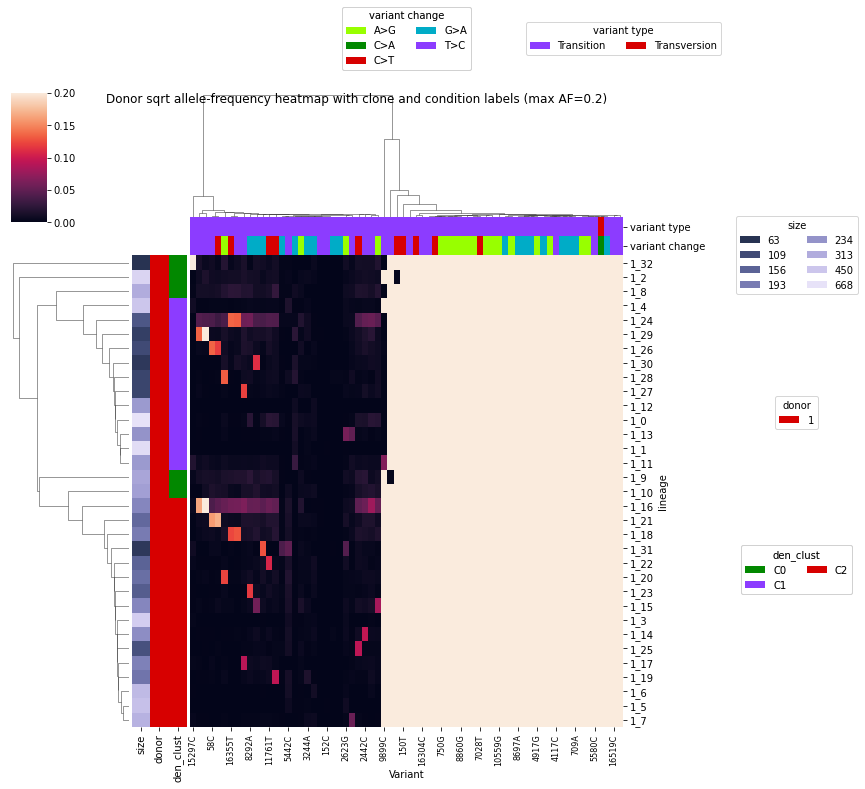

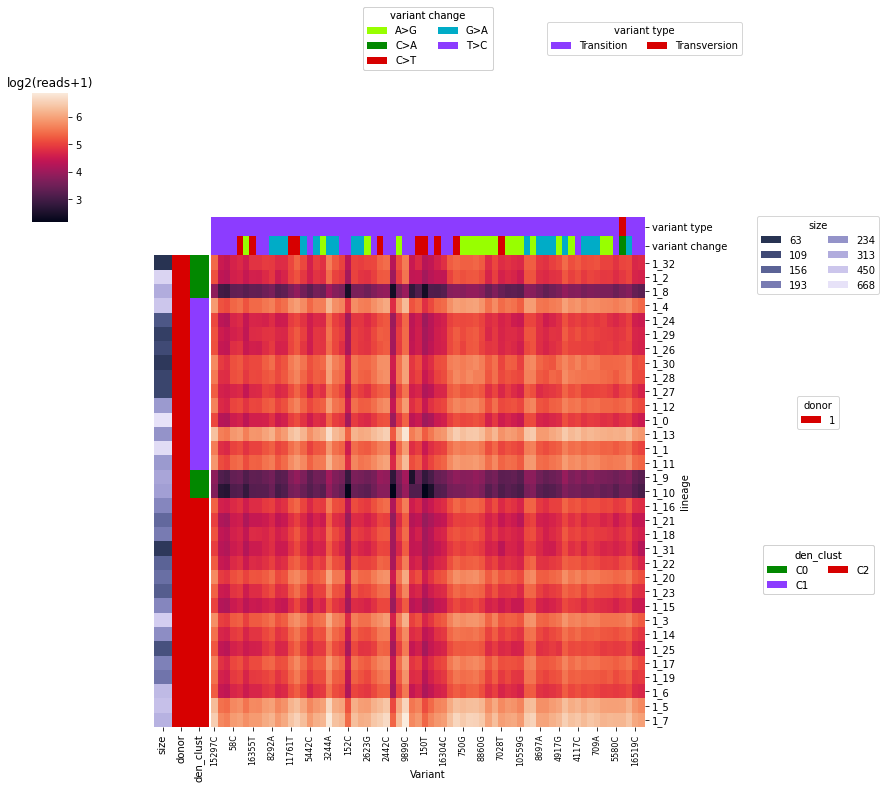

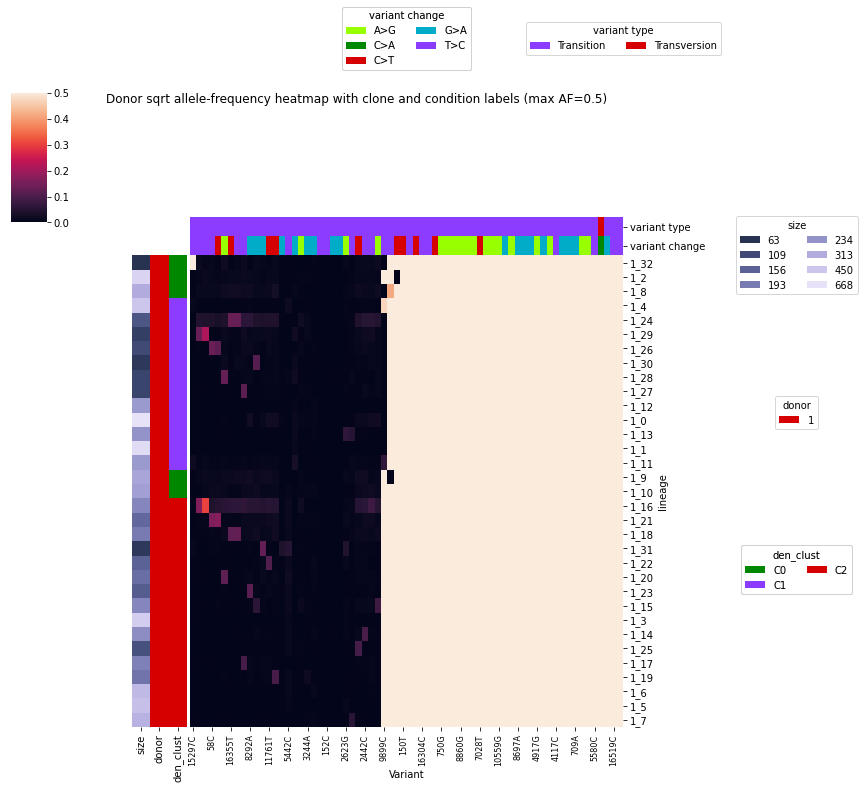

In [19]:
g = ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=True, to_col_clust=True,
                    col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                    row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                    vmax=0.2, vmin=0)
plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.2)")
#fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
fu.helper_save(out_f+".dendro.NoCondition.max2.AF.png",to_pdf=False)

inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]

g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                      row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                      col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                     )
g1d.ax_cbar.set_title("log2(reads+1)")
fu.helper_save(out_f+".dendro.NoCondition.DP.png")#, f=g1d.figure)


mean_af = mean_af.iloc[inds,cols]
curr_clones = curr_clones.loc[mean_af.index]

ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                vmax=0.5, vmin=0)
plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
#fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
fu.helper_save(out_f+".dendro.NoCondition.max5.AF.png",to_pdf=False)



In [20]:
out_f

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6/donor1'

### Save mean_af and curr_clonnes

In [21]:
mean_af.to_csv(out_f+".mean.csv")
curr_clones.to_csv(out_f+".clones_dendro.csv")